In [1201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon
import geopandas as gpd 
import pysal as ps

from pysal.explore import esda # Exploratory Spatial analytics
from pysal.lib import weights
from geopy.geocoders import Nominatim
import geoplot
import libpysal as lp
from pysal.lib import weights
import csv
%matplotlib inline

np.random.seed(123)

In [1870]:
np.set_printoptions(suppress=True, precision=2)

### Loading datasets 

In [1590]:
# shapefile with polygon geometries at the state level  and msa level
dataframe = gpd.read_file('state/cb_2018_us_state_500k.shp')
dataframe_msa = gpd.read_file('msa/CBSA__MSA__2019_US_SL310_Coast_Clipped.shp')
# fatal_police encounters dataset
shootings_df = pd.read_csv('fatal-police-shootings-data.csv')
# census dataset
state_census = pd.read_csv('5_year_by_state.csv')
# reading in police department makeup df
police_dep = pd.read_csv('police_makeup.csv', sep=(','), delimiter=(','))
census_city = pd.read_csv('5year_community_survey_city.csv', encoding='latin-1')

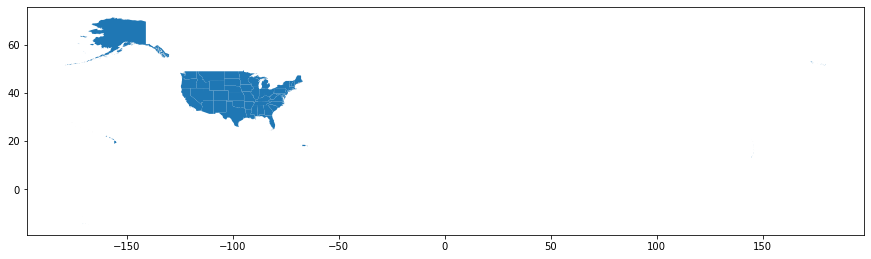

In [543]:
dataframe.plot(figsize=(15,10));

In [545]:
state_census.head()

,FIPS,Name of Area,Qualifying Name,State/U.S.-Abbreviation (USPS),State (FIPS),Geographic Identifier,area_land,area_water,pop_density,population,...,median_income_asian,median_income_hawaiian,median_income_other_race,median_income_2_races,median_income_latino,per_capita_income,Gini Index,median_gross_rent,households,households_rent_more_than_30
0,1,Alabama,Alabama,al,1,04000US01,1.311740e+11,4.593327e+09,96.051490,4864680,...,62639,55511.0,35181,42397,38314,26846,0.4797,772,1860269,424558
1,2,Alaska,Alaska,ak,2,04000US02,1.478840e+12,2.454820e+11,1.293411,738516,...,69685,63478.0,67348,66896,66283,35874,0.4237,1231,253462,67276
2,4,Arizona,Arizona,az,4,04000US04,2.941990e+11,1.027338e+09,61.155400,6946685,...,74430,59806.0,43471,52551,45610,29265,0.4681,1009,2524300,703932
3,5,Arkansas,Arkansas,ar,5,04000US05,1.347690e+11,2.962860e+09,57.474710,2990671,...,65919,35947.0,38589,38068,39787,25635,0.4765,729,1152175,254792
4,6,California,California,ca,6,04000US06,4.035040e+11,2.046387e+10,251.285800,39148760,...,91623,72432.0,52800,71932,55084,35021,0.4891,1429,12965435,5038127


In [546]:
shootings_df.head()

,id,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,year,month,location,geometry
0,486.0,2015-05-20,shot and Tasered,knife,39,F,W,Gillette,WY,False,other,Car,False,-105.450,44.302,2015,5,"Gillette, WY",POINT (-105.45000 44.30200)
1,636.0,2015-07-12,shot,gun,27,M,W,Casper,WY,False,attack,Not fleeing,False,-106.354,42.834,2015,7,"Casper, WY",POINT (-106.35400 42.83400)
2,656.0,2015-07-16,shot,gun,23,M,N,Cheyenne,WY,False,attack,Not fleeing,False,-104.826,41.117,2015,7,"Cheyenne, WY",POINT (-104.82600 41.11700)
3,672.0,2015-07-23,shot,toy weapon,47,M,W,Douglas,WY,False,attack,Not fleeing,False,-105.390,42.720,2015,7,"Douglas, WY",POINT (-105.39000 42.72000)
4,1065.0,2015-12-06,shot,knife,48,M,W,Laramie,WY,True,other,Not fleeing,False,-105.752,41.322,2015,12,"Laramie, WY",POINT (-105.75200 41.32200)


## 1. Data Exploation, Visualization, Pre-Processing

In [1831]:
no_undetermined = shootings_df[(shootings_df['race']!='undetermined') & (shootings_df['race']!='O')]

Text(0.5, 1.0, 'Total Shootings by Race')

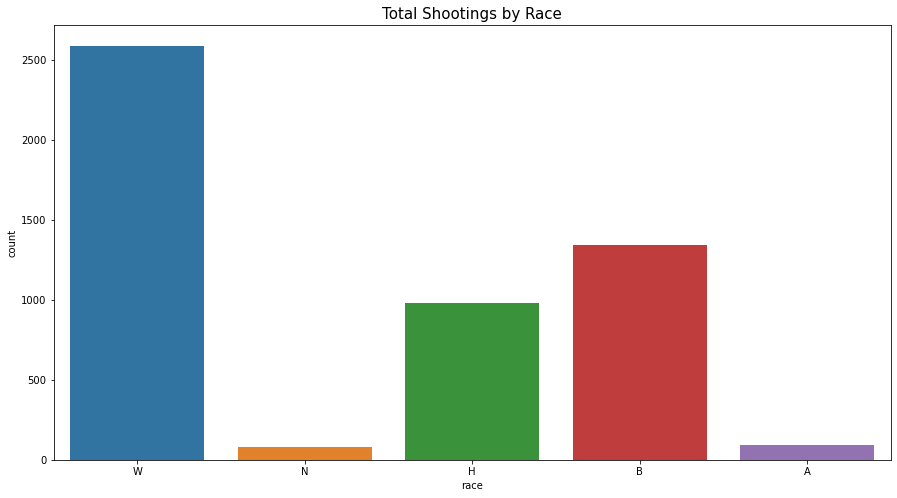

In [1836]:
# aggregate by race 
plt.figure(figsize=(15,8))
#chart = sns.distplot(shootings_weapon, x='armed');
sns.countplot(data=no_undetermined, x="race");
plt.title('Total Shootings by Race', fontdict={'fontsize':15})

Text(0.5, 1.0, 'Age Distribution of Victims by Race')

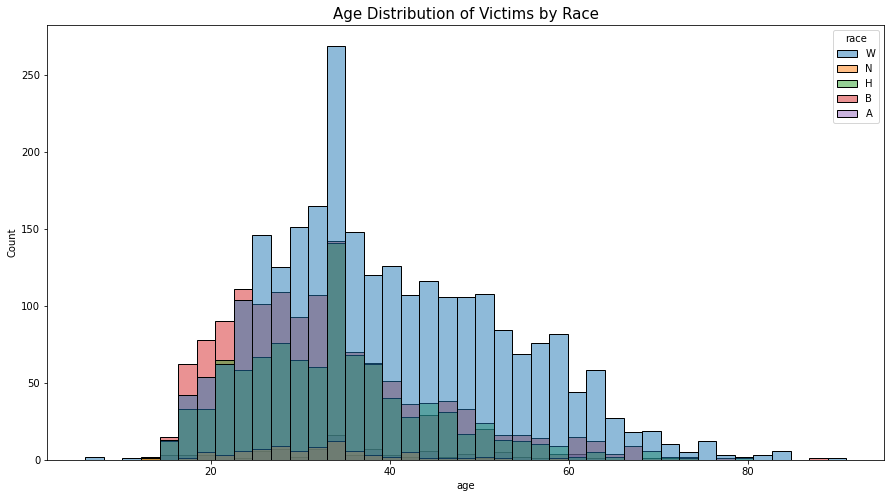

In [1837]:
# disrtibution of victims by age
no_undetermined = shootings_df[(shootings_df['race']!='undetermined') & (shootings_df['race']!='O')]
plt.figure(figsize=(15,8))
sns.histplot(no_undetermined, x='age', hue='race');
plt.title('Age Distribution of Victims by Race', fontdict={'fontsize':15})

In [1829]:
shootings_df['race'].value_counts()

W               2590
B               1345
H                982
undetermined     570
A                 93
N                 81
O                 40
Name: race, dtype: int64

Text(0.5, 1.0, 'State Shootings by Race')

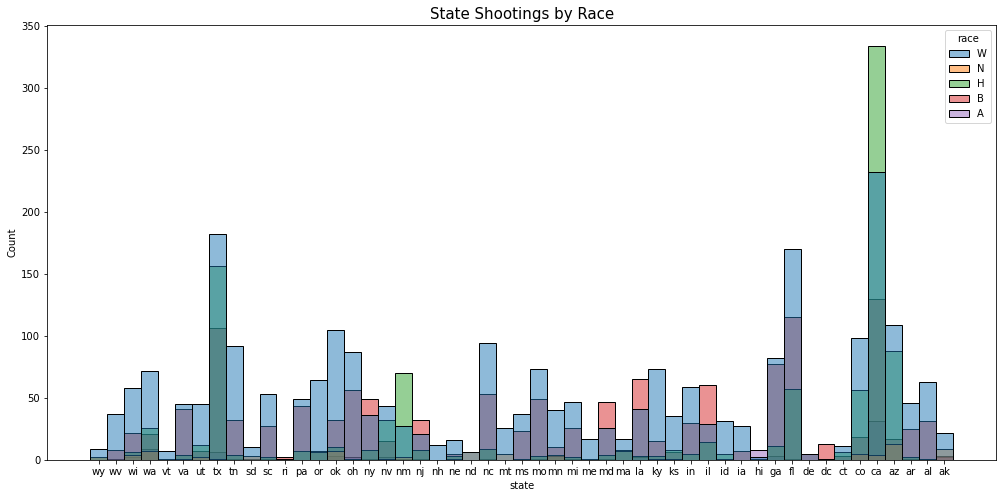

In [1838]:
# visualizing shootings by race
plt.figure(figsize=(17,8))
sns.histplot(no_undetermined, x='state', hue='race');
plt.title('State Shootings by Race', fontdict={'fontsize':15})

Text(0.5, 1.0, 'Most Affected Cities')

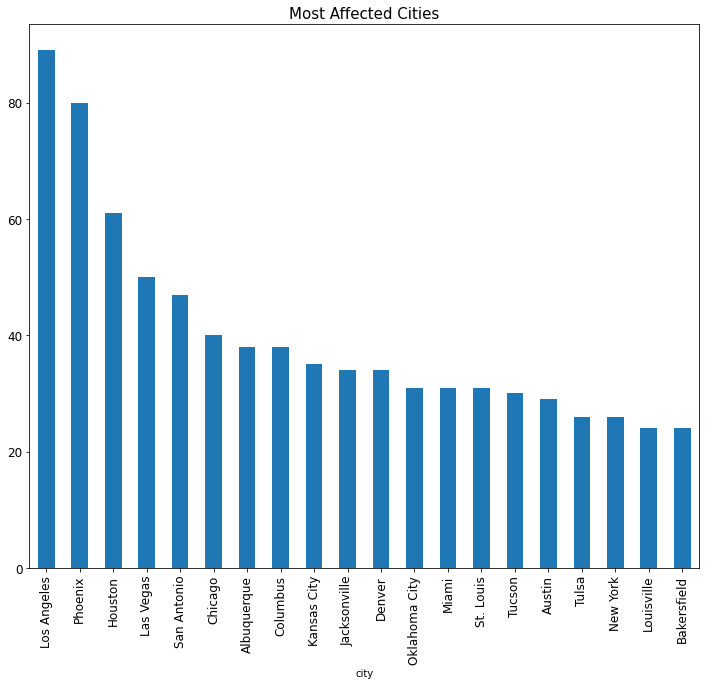

In [1797]:
# looking at the top 20 cities 
by_city=pd.DataFrame(shootings_df.groupby('city')[['id']].count()
                    ).reset_index().sort_values(by='id', ascending=False).head(20)

by_city.plot(x='city', y='id',kind='bar', 
             legend=False, figsize=(12,10),fontsize=12)
plt.title(label='Most Affected Cities',fontsize=15)

In [1591]:
# extracting state from police_dep dataframe
# converting string to list under name 
police_dep['name'] = police_dep["Name of Area"].apply(lambda x: list(x.split(", ",)) )
# getting state information 
police_dep['state'] = police_dep["name"].apply(lambda x: x[-1])

In [1592]:
# looks like there are 4 missing values in the state column here 
police_dep = police_dep.drop(columns=['Police Department', 'FIPS'])

In [1724]:
states = police_dep['state'].to_list()

In [1594]:
# I will manually replace 'DEPARTMENT,Florida', 'DEPARTMENT,Louisiana','DEPARTMENT,Georgia'
police_dep = police_dep.replace({'ALTAMONTE SPRINGS POLICE DEPARTMENT,Florida':'Florida', 
                                 'ALEXANDRIA POLICE DEPARTMENT,Louisiana':'Louisiana',
                                 'SAVANNAH CHATHAM METRO POLICE DEPARTMENT,Georgia':'Georgia',
                                 'CHARLOTTEMECKLENBURG POLICE DEPARTMENT,North Carolina':'North Carolina'})

In [1596]:
police_dep.sample(2)

,Name of Area,percent_white_police,percent_black_police,percent_asian_police,percent_hispanic_police,percent_other_police,name,state
14,"MESA POLICE DEPARTMENT, Arizona",79.23,3.86,2.40,13.72,0.80,"[MESA POLICE DEPARTMENT, Arizona]",Arizona
473,"NORTH BERGEN POLICE, New Jersey",42.86,0.00,0.84,55.46,0.84,"[NORTH BERGEN POLICE, New Jersey]",New Jersey


In [1597]:
# converting state name to lower since we need lower to join with other df's
shootings_df['state'] = [x.lower() for x in shootings_df['state']]

#### Converting date to actual date and extracting year/month

In [506]:
shootings_df['date'] = pd.to_datetime(shootings_df['date'])
# extracting year 
shootings_df['year'] = pd.DatetimeIndex(shootings_df['date']).year
# extracting month
shootings_df['month'] = pd.DatetimeIndex(shootings_df['date']).month

In [507]:
shootings_df = shootings_df.drop_duplicates()

In [509]:
shootings_df.shape

(5716, 19)

In [512]:
# dropping some columns
shootings_df = shootings_df.drop(columns=['is_geocoding_exact','name'])

#### Checking for missing values and imputing

In [851]:
police_dep.isnull().sum()

FIPS                        0
Police Department           0
percent_white_police       10
percent_black_police       10
percent_asian_police       10
percent_hispanic_police    10
percent_other_police       10
name                        0
state                       4
dtype: int64

In [853]:
# lookning to see where state info is missing 
police_dep[police_dep['state'].isnull()]

,FIPS,Police Department,percent_white_police,percent_black_police,percent_asian_police,percent_hispanic_police,percent_other_police,name,state
1,120950,120950,74.49,8.16,4.08,12.24,1.02,"ALTAMONTE SPRINGS POLICE DEPARTMENT,Florida",None
9,220975,220975,77.92,19.48,1.30,1.30,0.00,"ALEXANDRIA POLICE DEPARTMENT,Louisiana",None
445,1305199991,1305199991,61.37,30.77,1.84,5.02,1.00,"SAVANNAH CHATHAM METRO POLICE DEPARTMENT,Georgia",None
487,3711999991,3711999991,74.53,17.56,2.24,4.53,1.15,"CHARLOTTEMECKLENBURG POLICE DEPARTMENT,North C...",None


In [513]:
shootings_df.isnull().sum()

id                           0
date                         0
manner_of_death              0
armed                        0
age                          0
gender                       1
race                         0
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                         0
body_camera                  0
longitude                  259
latitude                   259
year                         0
month                        0
dtype: int64

##### Imputing age to median

In [511]:
shootings_df['age'] = shootings_df['age'].fillna((shootings_df['age'].median()))

In [514]:
# converting age to int
shootings_df['age'] = shootings_df['age'].astype(int)

#### Converting Categorical Variables

In [632]:
# converting gender to binary 
shootings_df = shootings_df.replace({'F':0, 'M':1})

In [633]:
# converting bools to ints 
shootings_df['body_camera'] = shootings_df['body_camera'].astype(int)
shootings_df['signs_of_mental_illness'] = shootings_df['signs_of_mental_illness'].astype(int)
shootings_df['id'] = shootings_df['id'].astype(int)

In [631]:
shootings_df.head(2)

,id,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,year,month,location,geometry
0,486,2015-05-20,shot and Tasered,knife,39,0.0,W,Gillette,wy,0,other,Car,0,-105.450,44.302,2015,5,"Gillette, WY",POINT (-105.45000 44.30200)
1,636,2015-07-12,shot,gun,27,1.0,W,Casper,wy,0,attack,Not fleeing,0,-106.354,42.834,2015,7,"Casper, WY",POINT (-106.35400 42.83400)


#### Geocoding missing lat/lon

In [519]:
# first I will combine 'city' and 'state' to get a location column to facilitate geocoding
shootings_df['location'] = shootings_df.city + ', ' + shootings_df.state

In [520]:
# creating df with all missing values 
missing_loc = shootings_df[shootings_df.longitude.isnull()]

In [521]:
missing_loc['location'].value_counts()

Oklahoma City, OK       4
Louisville, KY          4
Ogden, UT               3
Kansas City, MO         2
Charlotte, NC           2
                       ..
High Point, NC          1
Claiborne County, TN    1
Hernando, FL            1
Baton Rouge, LA         1
Daly City, CA           1
Name: location, Length: 239, dtype: int64

We have a total of 239 locations with no lat/lon that need to be filled out. For this, I will use Geolocator library. 

In [525]:
geolocator = Nominatim(user_agent='sh')

In [526]:
# creating geocoded object 
missing_loc['gcode'] = missing_loc.location.apply(geolocator.geocode)

<ipython-input-526-808cd6d32524>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_loc['gcode'] = missing_loc.location.apply(geolocator.geocode)


In [527]:
# removing a couple of missing values (no city information)
missing_loc= missing_loc[missing_loc.gcode.notna()]

In [528]:
missing_loc['latitude'] = [g.latitude for g in missing_loc.gcode]
missing_loc['longitude'] = [g.longitude for g in missing_loc.gcode]

<ipython-input-528-3bab3298cac9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_loc['latitude'] = [g.latitude for g in missing_loc.gcode]
<ipython-input-528-3bab3298cac9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_loc['longitude'] = [g.longitude for g in missing_loc.gcode]


In [529]:
# getting just the missing values 
missing_location = missing_loc[['id','longitude','latitude']]

In [530]:
# updating missing lat and lon values
shootings_df.update(missing_location)

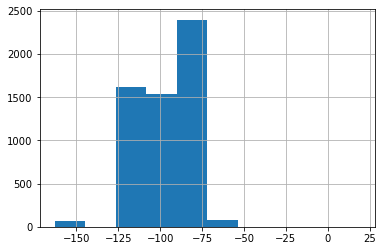

In [531]:
# looking at the resulting disribution 
shootings_df['longitude'].hist();


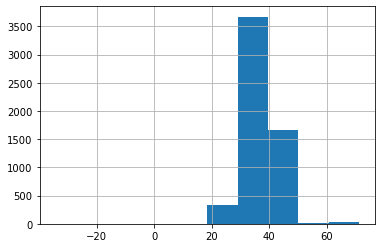

In [532]:
shootings_df['latitude'].hist();

There are clearly some errors - longitude can't be -25, 0 or 25 for the USA. I will manually filter this out. Similarly, latitude beyond 20 doesn't seem right either. 

In [533]:
shootings_df = shootings_df[(shootings_df.latitude > 20.0) & (shootings_df.longitude < -50.0)]

#### Creating Point Geometries

In [534]:
# creating a geometry column 
geometry = [Point(xy) for xy in zip(shootings_df['longitude'], shootings_df['latitude'])]
# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}
# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(shootings_df, crs=crs, geometry=geometry)


/Users/kseniyahusak/opt/anaconda3/envs/si649f20/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [535]:
# dropping all na values 
gdf = gdf[gdf['latitude'].notna()]

#### Visualizing all points 

<Figure size 1440x1440 with 0 Axes>

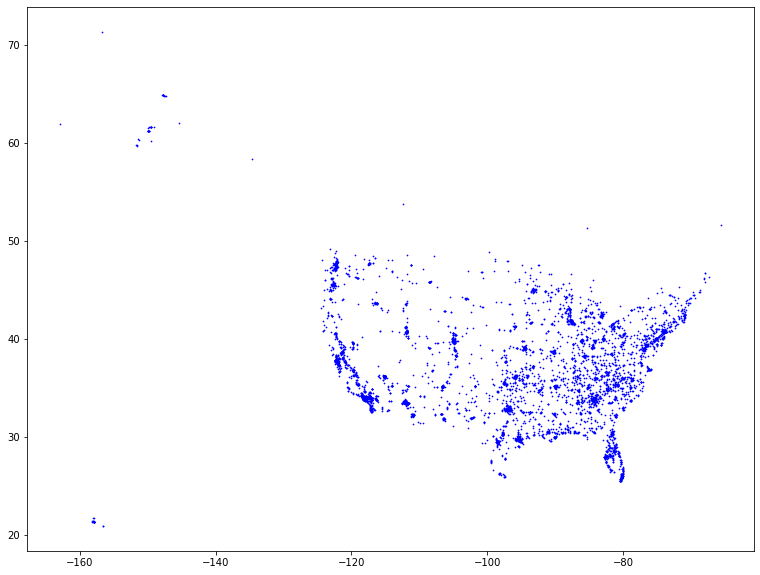

In [536]:
# Plotting all points with Geopandas 
plt.figure(figsize=(20,20));
gdf.plot(marker='o', color='b', markersize=0.5, figsize=(25,10));


There still seems to be some outliers (some points have been coded as in Canada). But overall, this shouldn't affect things too much. 

In [539]:
# Plotting all points with Folio
import folium 

my_map = folium.Map(zoom_start=5)
for index, row in gdf.iterrows():
    folium.Marker(location=(row['latitude'],row['longitude'])).add_to(my_map)


In [1344]:
display(my_map)

As we can see, in the first visualization, fatal police encounters are definitely clustered around more populous zones, as expected. 

#### Visualizations by year

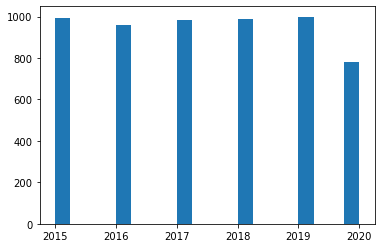

In [555]:
shootings_df['year'].hist(bins=20, grid=False);

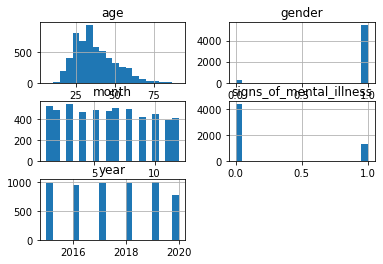

In [790]:
shootings_df[['age','gender','state','year','month','flee','signs_of_mental_illness']].hist(bins=20);

In [856]:
# saving clean file 
shootings_df.to_csv('clean_shootings_df.csv')

# 2. Spatial Analysis

### Performing Spatial Exploration and Analysis at the State Level

Initially I wanted to do spatial analysis aggregated at the city level. However, the only shapefiles I could find were at the statistical metropolitan area. That, however, was only available for 938 metropolitan areas. Since many of the obeservations in the police shootings file are not in the metropolitan areas, but rather small towns, I would have to loose 4/5 of my data (only 325 of places intersect). So, I will first aggregate at a higher level - namely state. Then I will merge the census data and the shapefile with polygons to my aggregated shootings df. 

In [1167]:
# checking to see if msa cities intersect with cities in the shootings df
shootings_city = shootings_df['location'].to_list()
msa = dataframe_msa['NAME'].to_list()
S1 = set(shootings_city)
S2 = set(msa)
intersection = list(S1.intersection(S2))
print('intersection: ', len(intersection))
print('msa :', len(msa))
print('shootings df cities :', len(shootings_city))

intersection:  325
msa : 938
shootings df cities : 5701


#### Aggregating shootings_df at the state level

In [638]:
# removing point geometries since I am swithing to polygon geometry 
shootings_df_no_geom = shootings_df.drop(columns=['geometry'])
# grouping by state
shootings_by_state = pd.DataFrame(shootings_df_no_geom.groupby('state')['id','gender','body_camera','signs_of_mental_illness'].count()).reset_index()

<ipython-input-638-8bd69e45bb58>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  shootings_by_state = pd.DataFrame(shootings_df_no_geom.groupby('state')['id','gender','body_camera','signs_of_mental_illness'].count()).reset_index()


In [639]:
shootings_by_state.head()

,state,id,gender,body_camera,signs_of_mental_illness
0,ak,40,40,40,40
1,al,105,105,105,105
2,ar,83,83,83,83
3,az,262,262,262,262
4,ca,853,853,853,853


#### Merging shootings dataset with census data and state-level shapefiles 

In [655]:
# Merging state census with shootings_df 
cumulative = pd.merge(shootings_by_state, state_census, left_on='state', right_on='State/U.S.-Abbreviation (USPS)')
# Merging cumulative with the shapefile at the state level 
final_df = pd.merge(cumulative, dataframe, left_on='Qualifying Name', right_on='NAME')

In [656]:
final_df.columns

Index(['state', 'id', 'gender', 'body_camera', 'signs_of_mental_illness',
       'FIPS', 'Name of Area', 'Qualifying Name',
       'State/U.S.-Abbreviation (USPS)', 'State (FIPS)',
       'Geographic Identifier', 'area_land', 'area_water', 'pop_density',
       'population', 'white', 'black', 'native', 'asian', 'hawaiian',
       'other_populatin', 'two_races_pop', 'avg_household_size', 'pop_25_over',
       'ed_less_than_hs', 'ed_hs', 'ed_some_college', 'ed_ba', 'ed_ma',
       'ed_prof_degree', 'ed_phd', 'total_laborforce', 'employed',
       'unemployed', 'median_household_income', 'median_income_white',
       'median_income_black', 'median_income_native', 'median_income_asian',
       'median_income_hawaiian', 'median_income_other_race',
       'median_income_2_races', 'median_income_latino', 'per_capita_income',
       'Gini Index', 'median_gross_rent', 'households',
       'households_rent_more_than_30', 'STATEFP', 'STATENS', 'AFFGEOID',
       'GEOID', 'STUSPS', 'NAME', 'LSAD',

In [657]:
# dropping some columns
final_df = final_df.drop(columns=['State/U.S.-Abbreviation (USPS)', 'State (FIPS)',
       'Geographic Identifier','FIPS','STATEFP', 'STATENS', 'AFFGEOID',
       'GEOID', 'STUSPS', 'NAME', 'LSAD', 'ALAND', 'AWATER','area_land', 'area_water','Name of Area'])

In [659]:
# normalizing total incidents by population in that state 
final_df['incident_dens'] = final_df['id']/final_df['population']

In [1725]:
# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
gdf_cumulative = gpd.GeoDataFrame(final_df, crs=crs, geometry=final_df['geometry'])

import contextily as ctx


/Users/kseniyahusak/opt/anaconda3/envs/si649f20/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Creating Spatial Weight Matrix 

Code for this section came from PySal, GeoPandas documentation and http://darribas.org/gds15/content/labs/lab_06.html

In [661]:
# Create the spatial weights matrix
Q_w = ps.lib.weights.Queen.from_dataframe(gdf_cumulative,idVariable='Qualifying Name')

/Users/kseniyahusak/opt/anaconda3/envs/si649f20/lib/python3.8/site-packages/pysal/lib/weights/weights.py:167: UserWarning: There are 2 disconnected observations 
  Island ids: Alaska, Hawaii
  warnings.warn("There are %d disconnected observations" % ni + ' \n '


In [662]:
# Row standardizing the matrix
Q_w.transform = 'R'

('WARNING: ', 'Alaska', ' is an island (no neighbors)')
('WARNING: ', 'Hawaii', ' is an island (no neighbors)')


In [663]:
# inspecting the weight for neighbors of Michigan
Q_w['Michigan']

{'Wisconsin': 0.3333333333333333,
 'Indiana': 0.3333333333333333,
 'Ohio': 0.3333333333333333}

#### Spatial Lag 

Once we have the data and the spatial weights matrix ready, we can start by computing the spatial lag of the police death density. The spatial lag is the product of the spatial weights matrix and a given variable, and since W
is row-standardized the result amounts to the average value of the variable in the neighborhood(state) of each observation.


In [664]:
gdf_cumulative['w_deaths_dens'] = weights.spatial_lag.lag_spatial(Q_w, gdf_cumulative['incident_dens'])

In [668]:
# checking a few spatial lags 
gdf_cumulative.sample(2)

,state,id,gender,body_camera,signs_of_mental_illness,Qualifying Name,pop_density,population,white,black,...,median_income_2_races,median_income_latino,per_capita_income,Gini Index,median_gross_rent,households,households_rent_more_than_30,geometry,incident_dens,w_deaths_dens
4,ca,853,853,853,853,California,251.28580,39148760,23529068,2267875,...,71932,55084,35021,0.4891,1429,12965435,5038127,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987...",0.000022,0.000022
5,co,208,208,208,208,Colorado,53.36948,5531141,4655584,227938,...,62783,50944,36415,0.4578,1196,2113387,629668,"POLYGON ((-109.06025 38.59933, -109.05954 38.7...",0.000038,0.000023


The spatial lag (w_deaths_dens) for California, where density of incidents is 2.2 per 100K of population, is surrounded by other states which have on average identical insident density. Colorado, on the other hand, which has police killing density of 3.8 per 100K of population, is surrounded by states that have on average lower police killing density - around 2.3 cases per 100K of population. 

In [678]:
# standardizing incident density 
gdf_cumulative['Deaths_dens_std'] = (gdf_cumulative['incident_dens'] - gdf_cumulative['incident_dens'].mean()) / gdf_cumulative['incident_dens'].std()

# Creating spatial lags of the spatial patterns of the standardized values (z-values)
gdf_cumulative['w_deaths_dens_std'] = weights.spatial_lag.lag_spatial(Q_w, gdf_cumulative['Deaths_dens_std'])

### Global Spatial autocorrelation

Here I will look at the overall graphical pattern of the data and will attempt to characterize the map in terms of its degree of clustering as well as summarize it. I will do Moran Plot and Moran's I statistics of spatial autocorrelation. The moran plotin particular helos with visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation, where variable of interest (death density) will be displayed against its spatial lag. In order to be able to interpret values as above or below the mean, and their quantities in terms of standard deviations, the variable of interest is usually standardized by substracting its mean and dividing it by its standard deviation.

#### Moran Plot

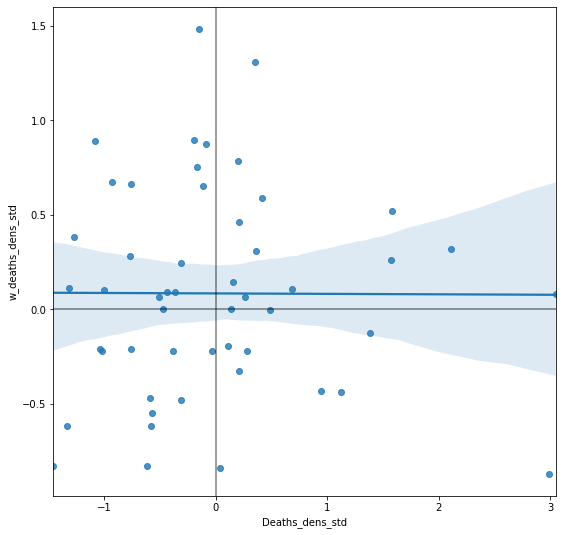

In [680]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Deaths_dens_std', y='w_deaths_dens_std', data=gdf_cumulative)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

Based on this plot, there does not appear to be a positiverelationship between the two variables, which suggestst that there is no positive spatial autocorrelation. This means that it's not the case that similar values tend to be located close to each other. So there isn't an overall trend for high values to be close to other high values, and reciprically, for low values being close to other low values. Of course, this doens't however mean that this is only situation in the dataset: there can particular cases where high values are surrounded by low ones, and viceversa. But generally it doesn't appear that values are clustered over space. 

I believe that this outcome is also a result of the level of aggregation - since I had to aggregate at the state level as opposed to city, the results might not be entirely reflective of reality at a more granular level. Intuitively I think spatial autcorrelation is present but we would need to looks at the data aggregated at the city level. At the state level, we can't see this pattern 

#### Moran 1

In [707]:
mi = esda.Moran(gdf_cumulative['incident_dens'], Q_w)

In [708]:
mi.I

-0.002480996285618095

The value of Moran's I representes the slope of the Moran Plot, and in this case it's almost 0 which confirms what the graph above displays - a flat erlationship. So, in this case, the particular spatial arrangement of values over space we observe for the density of deaths from encounters with police is as equally concentrated as if we were to randomly shuffle the incident densities among all of the states, resulting in no statistical significance, which I will calculate next.  

In [711]:
mi.p_sim

0.427

The p-value associated with the Moran's I of this map is way above the threshold for statistical significance of 0.05 (5%). So we cannot reject the hypothesis that the map is random. In other words, we cannot conclude that the map displays more spatial pattern that we would expect if the values had been randomly allocated to a particular location. Again, this is somewhat consistent with the expectation given that 

#### Local Spatial autocorrelation 

Since the Moran 1 statistic calculated above only gives insight into the global overall pattern/clustering, I am going to look futher into the local measure and see if there is any statistically significant clusters. To do so, I will use local indicators of spatial assocation (LISA) which will classify the objservations in a dataset into grour groups derived from the Moral Plot: high values surrounded by high values (HH),low values nearby other low values (LL), high values among low values (HL), and viceversa (LH). Then I will calculate the statistic for each quadrant. 

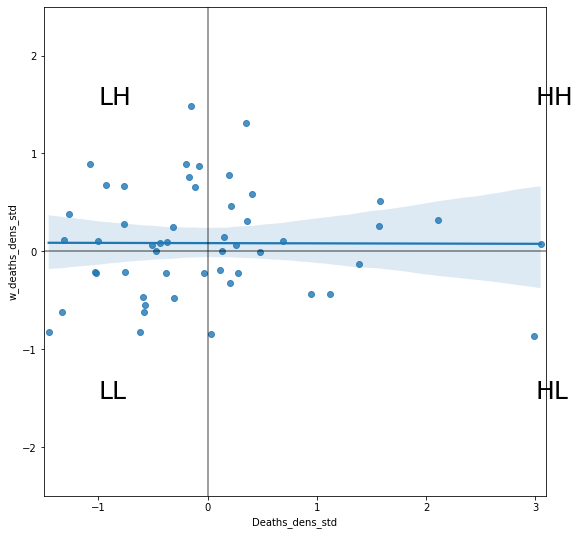

In [735]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Deaths_dens_std', y='w_deaths_dens_std', data=gdf_cumulative)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
ax.set_xlim(-1.5, 3.1)
ax.set_ylim(-2.5, 2.5)
plt.text(3, 1.5, "HH", fontsize=25)
plt.text(3, -1.5, "HL", fontsize=25)
plt.text(-1, 1.5, "LH", fontsize=25)
plt.text(-1, -1.5, "LL", fontsize=25)
# Display
plt.show()

In [715]:
lisa = esda.Moran_Local(gdf_cumulative['incident_dens'].values, Q_w)

/Users/kseniyahusak/opt/anaconda3/envs/si649f20/lib/python3.8/site-packages/pysal/explore/esda/moran.py:895: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/kseniyahusak/opt/anaconda3/envs/si649f20/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [716]:
# Break observations into significant or not
gdf_cumulative['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
gdf_cumulative['quadrant'] = lisa.q

In [717]:
gdf_cumulative['significant'].head()

0    False
1     True
2    False
3    False
4    False
Name: significant, dtype: bool

In [718]:
lisa.p_sim[:5]

array([0.359, 0.001, 0.363, 0.083, 0.355])

In [720]:
gdf_cumulative['quadrant'].head()

0    1
1    4
2    1
3    1
4    1
Name: quadrant, dtype: int64

It looks like one of the quadrant is actually statistically significant with p-value of 0.001 - namely the HL quadrant. 

### Performing Spatial Exploration and Analysis at the MSA Level

In [755]:
# aggregating by location
by_location = pd.DataFrame(shootings_df_no_geom.groupby(['location','state'])[['id']].count()).reset_index()

In [756]:
by_location 

,location,state,id
0,"Abbeville, AL",al,1
1,"Aberdeen, NC",nc,1
2,"Aberdeen, WA",wa,1
3,"Abilene, TX",tx,3
4,"Abingdon, MD",md,1
...,...,...,...
2887,"Yucca Valley, CA",ca,2
2888,"Yulee, FL",fl,2
2889,"Yuma, AZ",az,4
2890,"Zanesville, OH",oh,1


In [757]:
# Merging state census with shootings_df 
cumulative = pd.merge(by_location, state_census, left_on='state', right_on='State/U.S.-Abbreviation (USPS)')

In [758]:
cumulative.shape

(2892, 46)

In [763]:
# Merging cumulative with the shapefile at the msa level 
final_df_msa = pd.merge(cumulative, dataframe_msa, left_on='location', right_on='NAME')

In [764]:
final_df_msa.shape

(325, 64)

As noted previously, aggregating by Metropolitan statistical area results in a large loss of observations - from 2,892 to 325. However, I belive this might still be useful to analyze spacially to juxtapose with the 'state' level analysis. 

In [765]:
# normalizing total incidents by population in that state 
final_df_msa['incident_dens'] = final_df_msa['id']/final_df_msa['population']

#### Creating geographic df 

In [767]:
# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
gdf_cumulative_msa = gpd.GeoDataFrame(final_df_msa, crs=crs, geometry=final_df_msa['geometry'])

/Users/kseniyahusak/opt/anaconda3/envs/si649f20/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [855]:
# saving the msa geo-df to be visualized in CARTO
gdf_cumulative_msa.to_csv('msa_geo.csv')

### Creating Spatial Weight Matrix for msa, creating spatial lag and performing global spatial correlation



In [769]:
# Create the spatial weights matrix
Q_w = ps.lib.weights.Queen.from_dataframe(gdf_cumulative_msa,idVariable='NAME')

/Users/kseniyahusak/opt/anaconda3/envs/si649f20/lib/python3.8/site-packages/pysal/lib/weights/weights.py:167: UserWarning: There are 76 disconnected observations 
  Island ids: Akron, OH, Alexandria, LA, Anchorage, AK, Ardmore, OK, Atmore, AL, Bangor, ME, Bardstown, KY, Batesville, AR, Bay City, TX, Bellingham, WA, Bemidji, MN, Billings, MT, Bowling Green, KY, Burlington, NC, Cedar City, UT, Cedartown, GA, Coos Bay, OR, Corpus Christi, TX, Del Rio, TX, Dover, DE, East Stroudsburg, PA, Eau Claire, WI, Elkins, WV, Fairbanks, AK, Forrest City, AR, Fort Dodge, IA, Gainesville, GA, Grand Island, NE, Greenville, MS, Grenada, MS, Hays, KS, Henderson, NC, Huntsville, TX, Hutchinson, MN, Juneau, AK, Kerrville, TX, Kokomo, IN, Laredo, TX, Lawrenceburg, TN, Lincoln, NE, Magnolia, AR, Malone, NY, McAlester, OK, McMinnville, TN, Meridian, MS, Missoula, MT, Mobile, AL, Monroe, LA, Mountain Home, ID, Oak Harbor, WA, Owensboro, KY, Ozark, AL, Palestine, TX, Panama City, FL, Paris, TX, Peoria, IL, Pine

In [770]:
gdf_cumulative_msa['w_deaths_dens'] = weights.spatial_lag.lag_spatial(Q_w, gdf_cumulative_msa['incident_dens'])

In [771]:
# standardizing incident density 
gdf_cumulative_msa['Deaths_dens_std'] = (gdf_cumulative_msa['incident_dens'] - gdf_cumulative_msa['incident_dens'].mean()) / gdf_cumulative['incident_dens'].std()

# Creating spatial lags of the spatial patterns of the standardized values (z-values)
gdf_cumulative_msa['w_deaths_dens_std'] = weights.spatial_lag.lag_spatial(Q_w, gdf_cumulative_msa['Deaths_dens_std'])

In [773]:
gdf_cumulative_msa.head(2)

,location,state,id,FIPS,Name of Area,Qualifying Name,State/U.S.-Abbreviation (USPS),State (FIPS),Geographic Identifier,area_land,...,INTPTLON,Remainin~1,ID~1,STATEFP,TypeI,geometry,incident_dens,w_deaths_dens,Deaths_dens_std,w_deaths_dens_std
0,"Albertville, AL",al,1,1,Alabama,Alabama,al,1,04000US01,1.311740e+11,...,-086.3216681,0.000111,28332,11,3,"POLYGON ((-86.58175 34.31106, -86.58172 34.312...",2.055634e-07,0.000002,-0.05536,0.060947
1,"Atmore, AL",al,1,1,Alabama,Alabama,al,1,04000US01,1.311740e+11,...,-087.1684097,0.000157,28332,11,3,"POLYGON ((-87.18818 30.99838, -87.18824 30.998...",2.055634e-07,0.000001,-0.05536,0.045962


####  Moran Plot for MSA 

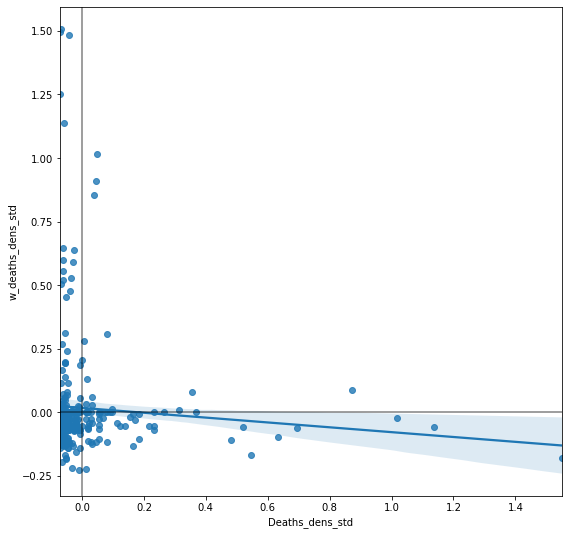

In [774]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Deaths_dens_std', y='w_deaths_dens_std', data=gdf_cumulative_msa)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

Based on this plot, there actually appears to be a slight negative spatial autocorrelation, in other words there is a slight negative correlation between standardized density of fatal police encounters for a given metropolitan statistical area and the averaged standardized density of fatal police encounters for the neighboring metropolitan statistical areas.  Although it's a weak relationship, it does suggest that dissimilar values tend to appear next to each other. 

#### Moran 1

In [775]:
mi_msa = esda.Moran(gdf_cumulative_msa['incident_dens'], Q_w)

('WARNING: ', 'Atmore, AL', ' is an island (no neighbors)')
('WARNING: ', 'Mobile, AL', ' is an island (no neighbors)')
('WARNING: ', 'Ozark, AL', ' is an island (no neighbors)')
('WARNING: ', 'Burlington, NC', ' is an island (no neighbors)')
('WARNING: ', 'Henderson, NC', ' is an island (no neighbors)')
('WARNING: ', 'Shelby, NC', ' is an island (no neighbors)')
('WARNING: ', 'Wilmington, NC', ' is an island (no neighbors)')
('WARNING: ', 'Winston-Salem, NC', ' is an island (no neighbors)')
('WARNING: ', 'Bellingham, WA', ' is an island (no neighbors)')
('WARNING: ', 'Oak Harbor, WA', ' is an island (no neighbors)')
('WARNING: ', 'Walla Walla, WA', ' is an island (no neighbors)')
('WARNING: ', 'Bay City, TX', ' is an island (no neighbors)')
('WARNING: ', 'Corpus Christi, TX', ' is an island (no neighbors)')
('WARNING: ', 'Del Rio, TX', ' is an island (no neighbors)')
('WARNING: ', 'Huntsville, TX', ' is an island (no neighbors)')
('WARNING: ', 'Kerrville, TX', ' is an island (no neigh

In [776]:
mi_msa.I

-0.0526655283107814

In [777]:
mi_msa.p_sim

0.192

The relationship between the variable of interest and its lag is negative although it is not statistically significant. However, as expected, the relationship is stronger when we aggregate fatal police encounters at the MSA level as opposed to state level as is evidenced by the slope of the Moran plot. For MSA's it's -0.052 and for state-level it is -0.0024. Although the improvement in the relationship did not achieve statistical significance, I believe that it's a step in the right direction - we want to do spatial analysis at as detailed of a level as possible since patterns of fatal police encounters are probably subject to many local variables as opposed to global ones. One big limitation of this analysis is also the loss of a lot of the data, since the observations are located in places that did not map to census obtained MSA's shape file. Having better shape file that doesn't result in so much lost date could probably improve the outcomes. Moreover, a number of msa's didn't have a neighbor, so I believe this affected the analysis - exploring techniques as a workaround for this would be great (however, I ran out of time). I think the ideal unit for aggregation would be a county, because there would be more continuity in that case (so fewer island polygons) and we could really udnerstand if police violence is clustered in certain parts of the state (I believe it is based on point visualizations). 

Overall, it seems that high density of fatal police encounters tends to happen in non-randomly and there is a pattern to the violence - some areas experience more of it than others. From the basic visualizations performed in the exploratory portion we can see that there is definitely clustering around large cities with greater population density. 

# 3. Predicting Race with Machine Learning 

In [1598]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import model_selection

For the ML component of predicting the race of the victim, I will use census data along with the fatalities data and police data. The census data contains demographic information at the state level, and the police data contains makeup of the police dapartment by police department. Because there isn't city/town/village level census data that would apply to all of the cities/towns/villages in my shootings_df dataset, I will have to use state demographics. Similarly, because there is no easy way to map individual police department statistics to city/village/town on the shootings_df, I will use the average values aggregated at the state level. Of course, I am aware that this limits the accuracy of my analysis - it would have been much better to look at the the most basic level of aggregation because states differ dramatically across cities in terms of populations, demographics, and crime. However, I will use this as an approximation analysis. 

In [1727]:
# Merging state census with shootings_df 
features = pd.merge(shootings_df_no_geom, state_census, left_on='state', right_on='State/U.S.-Abbreviation (USPS)',how='right')

In [1728]:
# aggregating police df 
police_dep = police_dep.groupby('state').mean().reset_index()

In [1729]:
police_dep.head(1)

,state,percent_white_police,percent_black_police,percent_asian_police,percent_hispanic_police
0,Alabama,70.974286,26.75,0.748571,1.12


Since all five columns add up to 100 in the police department df, I will drop one column to avoid the problem of multicolinearity. I will drop percent_other_police (this will serve as the baseline)

In [1731]:
#police_dep = police_dep.drop(columns='percent_other_police')

In [1634]:
# fixing some state names
police_dep = police_dep.replace({'Columbia':'District of Columbia', 'Hampshire':'New Hampshire', 
                                 'Jersey':'New Jersey',
       'Mexico':'New Mexico', 'York':'New York', 'Carolina':'North Carolina', 
                                 'Dakota':'North Dakota',
       'Rice':'Puerto Rico', 'Island':'Rhode Island', 'Carolina':'South Carolina', 'Dakota':'South Dakota',
       'Virginia':'West Virginia'})

In [1635]:
# merging features with police department dataframe
features_total = pd.merge(features, police_dep, left_on='Qualifying Name', right_on='state', how='left')

In [1636]:
census_city['State'] = census_city['State'].apply(lambda x: x.lower())

In [1637]:
census_city.head(1)

,FIPS,city,name,State,area_land,pop_white,pop_black,pop_native,pop_asian,pop_hawaiian,...,owner_housing_white,owner_housing_non_white,Median Gross Rent,avg_rent,paying_30_home,paying_at_least_50,avg_commute,poverty_overall,poverty_male,poverty_female
0,10100,Aberdeen,"Aberdeen, SD Micro Area",sd,2839.011047,38820,840,1249,1158,0,...,11546,419,676,698.996887,1804.0,724.0,13.0,4743.0,2058.0,2685.0


In [1638]:
features_total.head()

,id,date,manner_of_death,armed,age,gender,race,city,state_x,signs_of_mental_illness,...,per_capita_income,Gini Index,median_gross_rent,households,households_rent_more_than_30,state_y,percent_white_police,percent_black_police,percent_asian_police,percent_hispanic_police
0,486.0,2015-05-20,shot and Tasered,knife,39.0,0.0,W,Gillette,wy,0.0,...,32295,0.4347,843,230630,47998,NaN,NaN,NaN,NaN,NaN
1,636.0,2015-07-12,shot,gun,27.0,1.0,W,Casper,wy,0.0,...,32295,0.4347,843,230630,47998,NaN,NaN,NaN,NaN,NaN
2,656.0,2015-07-16,shot,gun,23.0,1.0,N,Cheyenne,wy,0.0,...,32295,0.4347,843,230630,47998,NaN,NaN,NaN,NaN,NaN
3,672.0,2015-07-23,shot,toy weapon,47.0,1.0,W,Douglas,wy,0.0,...,32295,0.4347,843,230630,47998,NaN,NaN,NaN,NaN,NaN
4,1065.0,2015-12-06,shot,knife,48.0,1.0,W,Laramie,wy,1.0,...,32295,0.4347,843,230630,47998,NaN,NaN,NaN,NaN,NaN


In [1639]:
features_total.shape, shootings_df_no_geom.shape

((5702, 66), (5701, 18))

In [1640]:
# dropping other columns I won't need
features_clean = features_total.drop(columns=['FIPS', 'Name of Area', 'Qualifying Name',
       'State/U.S.-Abbreviation (USPS)', 'State (FIPS)','id',
       'Geographic Identifier', 'area_land', 'area_water','longitude', 'latitude', 'city','state_y'])

In [1641]:
features_clean.head()

,date,manner_of_death,armed,age,gender,race,state_x,signs_of_mental_illness,threat_level,flee,...,median_income_latino,per_capita_income,Gini Index,median_gross_rent,households,households_rent_more_than_30,percent_white_police,percent_black_police,percent_asian_police,percent_hispanic_police
0,2015-05-20,shot and Tasered,knife,39.0,0.0,W,wy,0.0,other,Car,...,49059,32295,0.4347,843,230630,47998,NaN,NaN,NaN,NaN
1,2015-07-12,shot,gun,27.0,1.0,W,wy,0.0,attack,Not fleeing,...,49059,32295,0.4347,843,230630,47998,NaN,NaN,NaN,NaN
2,2015-07-16,shot,gun,23.0,1.0,N,wy,0.0,attack,Not fleeing,...,49059,32295,0.4347,843,230630,47998,NaN,NaN,NaN,NaN
3,2015-07-23,shot,toy weapon,47.0,1.0,W,wy,0.0,attack,Not fleeing,...,49059,32295,0.4347,843,230630,47998,NaN,NaN,NaN,NaN
4,2015-12-06,shot,knife,48.0,1.0,W,wy,1.0,other,Not fleeing,...,49059,32295,0.4347,843,230630,47998,NaN,NaN,NaN,NaN


In [1642]:
# dropping last row 
features_clean.drop(features_clean.tail(1).index,inplace=True)

### Visualizing distributions of features

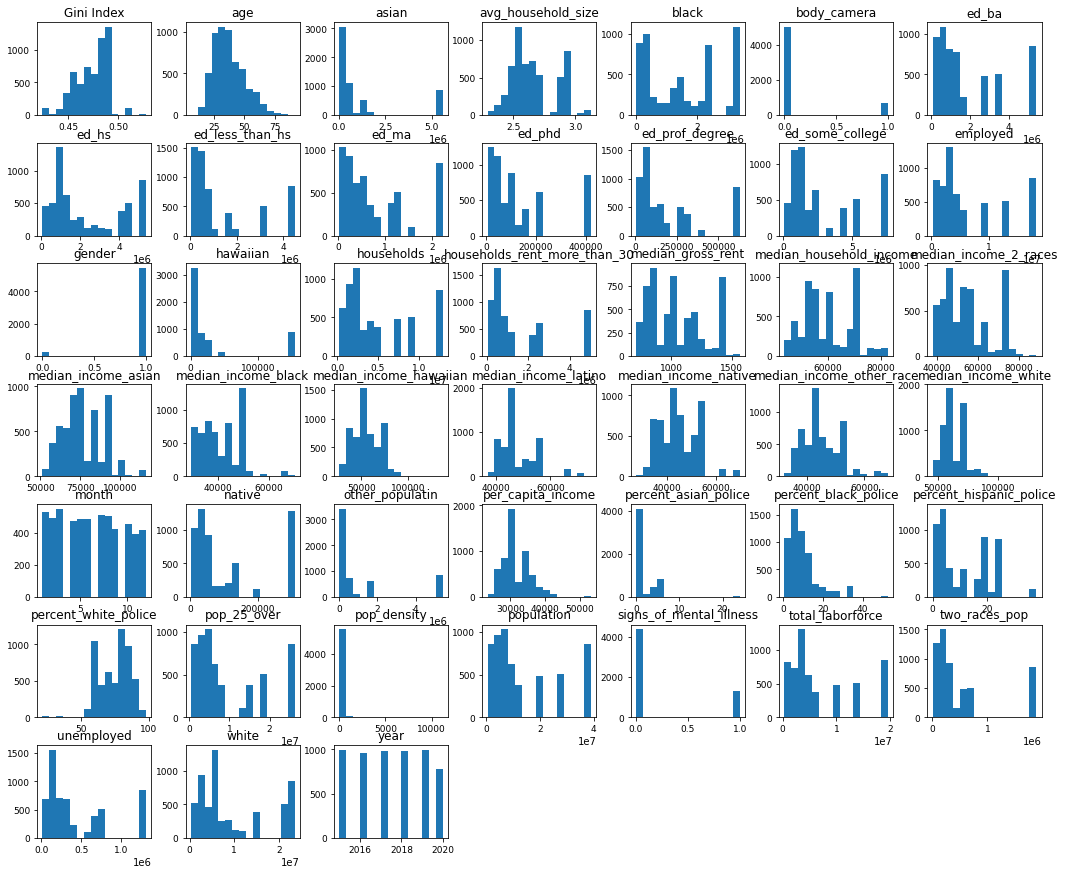

In [1266]:
# plotting distribution of features 
features_clean.hist(figsize=(18,15),grid=False, bins=15, ylabelsize=9, xlabelsize=9);

### Imputing missing values 

In [1267]:
features_clean.isnull().sum()

date                              0
manner_of_death                   0
armed                             0
age                               0
gender                            1
race                              0
state_x                           0
signs_of_mental_illness           0
threat_level                      0
flee                              0
body_camera                       0
year                              0
month                             0
location                          0
pop_density                       0
population                        0
white                             0
black                             0
native                            0
asian                             0
hawaiian                          0
other_populatin                   0
two_races_pop                     0
avg_household_size                0
pop_25_over                       0
ed_less_than_hs                   0
ed_hs                             0
ed_some_college             

In [1268]:
features_clean.head(2)

,date,manner_of_death,armed,age,gender,race,state_x,signs_of_mental_illness,threat_level,flee,...,median_income_latino,per_capita_income,Gini Index,median_gross_rent,households,households_rent_more_than_30,percent_white_police,percent_black_police,percent_asian_police,percent_hispanic_police
0,2015-05-20,shot and Tasered,knife,39.0,0.0,W,wy,0.0,other,Car,...,49059,32295,0.4347,843,230630,47998,NaN,NaN,NaN,NaN
1,2015-07-12,shot,gun,27.0,1.0,W,wy,0.0,attack,Not fleeing,...,49059,32295,0.4347,843,230630,47998,NaN,NaN,NaN,NaN


#### Imputing missing values with media 

In [1643]:
features_clean['percent_white_police'].fillna((features_clean['percent_white_police'].median()), inplace=True)
features_clean['percent_black_police'].fillna((features_clean['percent_black_police'].median()), inplace=True)
features_clean['percent_asian_police'].fillna((features_clean['percent_asian_police'].median()), inplace=True)
features_clean['percent_hispanic_police'].fillna((features_clean['percent_hispanic_police'].median()), inplace=True)
features_clean['median_income_hawaiian'].fillna((features_clean['median_income_hawaiian'].median()), inplace=True)
features_clean['gender'].fillna(1, inplace=True)

### Feature Engineering and Selection

Since what I am predicting in this part of my project is the race of a victim, it's improtant to have race information accurate. So, I will drop the 570 observations where we do not have race information (where race==undetermined). 

In [1644]:
features_clean[features_clean['race']!='undetermined']

,date,manner_of_death,armed,age,gender,race,state_x,signs_of_mental_illness,threat_level,flee,...,median_income_latino,per_capita_income,Gini Index,median_gross_rent,households,households_rent_more_than_30,percent_white_police,percent_black_police,percent_asian_police,percent_hispanic_police
0,2015-05-20,shot and Tasered,knife,39.0,0.0,W,wy,0.0,other,Car,...,49059,32295,0.4347,843,230630,47998,78.087143,7.6575,1.316154,6.08
1,2015-07-12,shot,gun,27.0,1.0,W,wy,0.0,attack,Not fleeing,...,49059,32295,0.4347,843,230630,47998,78.087143,7.6575,1.316154,6.08
2,2015-07-16,shot,gun,23.0,1.0,N,wy,0.0,attack,Not fleeing,...,49059,32295,0.4347,843,230630,47998,78.087143,7.6575,1.316154,6.08
3,2015-07-23,shot,toy weapon,47.0,1.0,W,wy,0.0,attack,Not fleeing,...,49059,32295,0.4347,843,230630,47998,78.087143,7.6575,1.316154,6.08
4,2015-12-06,shot,knife,48.0,1.0,W,wy,1.0,other,Not fleeing,...,49059,32295,0.4347,843,230630,47998,78.087143,7.6575,1.316154,6.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5695,2020-01-23,shot,gun,26.0,1.0,W,ak,0.0,attack,Car,...,66283,35874,0.4237,1231,253462,67276,80.670000,4.9000,4.640000,5.41
5696,2020-01-29,shot,gun,32.0,1.0,W,ak,0.0,attack,Foot,...,66283,35874,0.4237,1231,253462,67276,80.670000,4.9000,4.640000,5.41
5697,2020-02-15,shot,gun,16.0,1.0,A,ak,0.0,attack,Not fleeing,...,66283,35874,0.4237,1231,253462,67276,80.670000,4.9000,4.640000,5.41
5698,2020-03-08,shot,unarmed,37.0,1.0,W,ak,0.0,attack,Not fleeing,...,66283,35874,0.4237,1231,253462,67276,80.670000,4.9000,4.640000,5.41


In [1645]:
# dropped race=undetermined 
features_clean = features_clean[features_clean['race']!='undetermined']

In [1646]:
features_clean.shape

(5131, 53)

Taking a closer look at the categorical variables that will be converted to dummies for the purposes of machine learning. Since there are many towns/villages/cities in the dataset, I won't be using all of the city information as features. Instead, I will pick the top 40 locations in terms of total number of fatalities and convert them into dummy variables. 

In [1219]:
features_clean.race.value_counts()

W               2590
B               1345
H                982
undetermined     570
A                 93
N                 81
O                 40
Name: race, dtype: int64

In [1220]:
features_clean.threat_level.value_counts()

attack          3689
other           1756
undetermined     256
Name: threat_level, dtype: int64

In [1221]:
features_clean.flee.value_counts()

Not fleeing     3556
Car              934
Foot             736
undetermined     290
Other            185
Name: flee, dtype: int64

In [1647]:
# saving top 40 deadliest cities to be used for features 
by_location = pd.DataFrame(features_clean.location.value_counts())
top_40_cities = by_location.head(40).index.to_list()

In [1614]:
print(top_40_cities)

['Los Angeles, CA', 'Phoenix, AZ', 'Houston, TX', 'Las Vegas, NV', 'San Antonio, TX', 'Chicago, IL', 'Albuquerque, NM', 'Denver, CO', 'Columbus, OH', 'St. Louis, MO', 'Oklahoma City, OK', 'Tucson, AZ', 'Jacksonville, FL', 'Miami, FL', 'Kansas City, MO', 'Austin, TX', 'Tulsa, OK', 'New York, NY', 'Bakersfield, CA', 'Atlanta, GA', 'Louisville, KY', 'Mesa, AZ', 'Orlando, FL', 'Fresno, CA', 'San Jose, CA', 'Baltimore, MD', 'Indianapolis, IN', 'Pueblo, CO', 'Long Beach, CA', 'Philadelphia, PA', 'San Diego, CA', 'Charlotte, NC', 'Fort Worth, TX', 'Portland, OR', 'San Francisco, CA', 'Dallas, TX', 'San Bernardino, CA', 'Colorado Springs, CO', 'Aurora, CO', 'Milwaukee, WI']


In [1615]:
features_clean.columns

Index(['date', 'manner_of_death', 'armed', 'age', 'gender', 'race', 'state_x',
       'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera',
       'year', 'month', 'location', 'pop_density', 'population', 'white',
       'black', 'native', 'asian', 'hawaiian', 'other_populatin',
       'two_races_pop', 'avg_household_size', 'pop_25_over', 'ed_less_than_hs',
       'ed_hs', 'ed_some_college', 'ed_ba', 'ed_ma', 'ed_prof_degree',
       'ed_phd', 'total_laborforce', 'employed', 'unemployed',
       'median_household_income', 'median_income_white', 'median_income_black',
       'median_income_native', 'median_income_asian', 'median_income_hawaiian',
       'median_income_other_race', 'median_income_2_races',
       'median_income_latino', 'per_capita_income', 'Gini Index',
       'median_gross_rent', 'households', 'households_rent_more_than_30',
       'percent_white_police', 'percent_black_police', 'percent_asian_police',
       'percent_hispanic_police'],
      dtype='object'

In [1648]:
# dropping additional columns
features_clean = features_clean.drop(columns=['other_populatin','median_income_other_race','households'])

In [1649]:
features_clean.head()

,date,manner_of_death,armed,age,gender,race,state_x,signs_of_mental_illness,threat_level,flee,...,median_income_2_races,median_income_latino,per_capita_income,Gini Index,median_gross_rent,households_rent_more_than_30,percent_white_police,percent_black_police,percent_asian_police,percent_hispanic_police
0,2015-05-20,shot and Tasered,knife,39.0,0.0,W,wy,0.0,other,Car,...,54317,49059,32295,0.4347,843,47998,78.087143,7.6575,1.316154,6.08
1,2015-07-12,shot,gun,27.0,1.0,W,wy,0.0,attack,Not fleeing,...,54317,49059,32295,0.4347,843,47998,78.087143,7.6575,1.316154,6.08
2,2015-07-16,shot,gun,23.0,1.0,N,wy,0.0,attack,Not fleeing,...,54317,49059,32295,0.4347,843,47998,78.087143,7.6575,1.316154,6.08
3,2015-07-23,shot,toy weapon,47.0,1.0,W,wy,0.0,attack,Not fleeing,...,54317,49059,32295,0.4347,843,47998,78.087143,7.6575,1.316154,6.08
4,2015-12-06,shot,knife,48.0,1.0,W,wy,1.0,other,Not fleeing,...,54317,49059,32295,0.4347,843,47998,78.087143,7.6575,1.316154,6.08


#### Encoding categorical variables 

In [1652]:
# getting dummies/dropping first col to avoid autocorrelation
features_transformed = pd.get_dummies(features_clean, 
                                      columns=['state_x'],
                                      drop_first=True,prefix='', prefix_sep='')

# dropping columns
features_transformed = features_transformed.drop(columns=['location'])

In [1653]:
# getting cities
location = pd.get_dummies(features_clean, columns=['location'],drop_first=True,prefix='', prefix_sep='')
location_filtered = location.loc[:, location.columns.isin(top_40_cities)]
location_filtered.shape

(5131, 40)

In [1654]:
features_transformed.shape

(5131, 98)

In [1655]:
# concatenating cities with main features 
features_final = pd.concat([features_transformed,location_filtered],axis=1)

In [1656]:
features_final.head()

,date,manner_of_death,armed,age,gender,race,signs_of_mental_illness,threat_level,flee,body_camera,...,"Pueblo, CO","Salt Lake City, UT","San Antonio, TX","San Bernardino, CA","San Diego, CA","San Francisco, CA","San Jose, CA","St. Louis, MO","Tucson, AZ","Tulsa, OK"
0,2015-05-20,shot and Tasered,knife,39.0,0.0,W,0.0,other,Car,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2015-07-12,shot,gun,27.0,1.0,W,0.0,attack,Not fleeing,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2015-07-16,shot,gun,23.0,1.0,N,0.0,attack,Not fleeing,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2015-07-23,shot,toy weapon,47.0,1.0,W,0.0,attack,Not fleeing,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2015-12-06,shot,knife,48.0,1.0,W,1.0,other,Not fleeing,0.0,...,0,0,0,0,0,0,0,0,0,0


In [1657]:
# replacing values in 'armed' to binary where unarmed=0 and everything else is 1
features_final['armed'] = np.where(features_final['armed'] == 'unarmed', 0, 1)
# replaces values in threat level where attack=1 otherwise 0
features_final['threat_level']= np.where(['threat_level'] =='attack',1,0)

# replaces values in feeling level where feeling=1 otherwise 0
features_final['flee']= np.where(['fee'] =='Not fleeing',0,1)

In [1658]:
# replaces values in 'manner of death' to binary where shot=1, and 'shot and tasered' =0
features_final['manner_of_death']= np.where(['manner_of_death'] =='shot',1,0)

#### Selection features

Currently, there are 146 features total. Something tells me this is too many features. Because I am not taking into account the temporal dimension here (year/month is not going to be used as a feature since I only have census data at a 5-year level as opposed to by year and it seems that rates of fatal police encounters have been the same throughout the years), I will drop date and year. I will keep month however as it might be a proxy for public encounters in general due to warmer months/spending more time outdoors? I will use iterative feature selection to see what other features are important. 

In [1659]:
features_final.shape

(5131, 138)

#### Splitting data into train and test, and then validation

In [1901]:
from sklearn.model_selection import train_test_split

X = features_final.drop(columns=['race','year','date'])
y = features_final['race']

# I will stratify by 'race' given the class imbalance in my data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify= y)

#### model-based feature selection

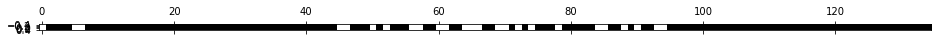

In [1892]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=110)
#select = RFE(LogisticRegression(penalty="l1"), n_features_to_select=40)
select.fit(X_train, y_train)
# visualize the selected features:
mask = select.get_support(indices=False)
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [1893]:
# visualizing results 
value = pd.DataFrame(mask, columns=['selected'])
name=pd.DataFrame(X_train.columns, columns=['features'])
result = pd.concat([name,value],axis=1)
result[result['selected']==False]

,features,selected
0,manner_of_death,False
5,threat_level,False
6,flee,False
45,al,False
46,ar,False
50,ct,False
52,de,False
56,ia,False
57,id,False
60,ks,False


In [1894]:
# a list of feature names that were discarded 
discarded_features = result[result['selected']==False]['features'].to_list()

##### Looks like the state information is not all that useful. I will drop all of them. I think important information is captured by including particular cities, so I don't think dripping state information will be bad.   Also, manner of death 

In [1895]:
# transforming 
X_train_select = select.transform(X_train)
X_test_select = select.transform(X_test)
# checking shape
X_test_select.shape, X_train_select.shape

((1283, 110), (3848, 110))

### Random Forest 

In [1949]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train_select, y_train)
rfc_pred = rfc.predict(X_test_select)
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           A       0.13      0.09      0.11        23
           B       0.51      0.46      0.48       336
           H       0.41      0.39      0.40       246
           N       0.11      0.05      0.07        20
           O       0.17      0.10      0.12        10
           W       0.64      0.71      0.67       648

    accuracy                           0.55      1283
   macro avg       0.33      0.30      0.31      1283
weighted avg       0.54      0.55      0.55      1283



In [1950]:
from sklearn.metrics import accuracy_score

# Accuracy score
rf_accuracy_score = accuracy_score(y_test, rfc_pred)
rf_accuracy_score

0.5549493374902572

In [1951]:
# taking a closer look at the most important features
all_features = X_train.columns.to_list()
selected_features= [i for i in all_features if i not in discarded_features]

In [1952]:
feature_data = pd.DataFrame({"feature_name": selected_features, "feature_importance": rfc.feature_importances_}) 
feature_data.sort_values(by='feature_importance', ascending=False).head(50)

,feature_name,feature_importance
1,age,0.406198
5,month,0.248169
3,signs_of_mental_illness,0.042785
4,body_camera,0.031789
0,armed,0.021894
2,gender,0.015805
41,percent_hispanic_police,0.010728
39,percent_black_police,0.010407
38,percent_white_police,0.009238
10,native,0.008842


In [1902]:
print(X.columns.to_list())

['manner_of_death', 'armed', 'age', 'gender', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera', 'month', 'pop_density', 'population', 'white', 'black', 'native', 'asian', 'hawaiian', 'two_races_pop', 'avg_household_size', 'pop_25_over', 'ed_less_than_hs', 'ed_hs', 'ed_some_college', 'ed_ba', 'ed_ma', 'ed_prof_degree', 'ed_phd', 'total_laborforce', 'employed', 'unemployed', 'median_household_income', 'median_income_white', 'median_income_black', 'median_income_native', 'median_income_asian', 'median_income_hawaiian', 'median_income_2_races', 'median_income_latino', 'per_capita_income', 'Gini Index', 'median_gross_rent', 'households_rent_more_than_30', 'percent_white_police', 'percent_black_police', 'percent_asian_police', 'percent_hispanic_police', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa'

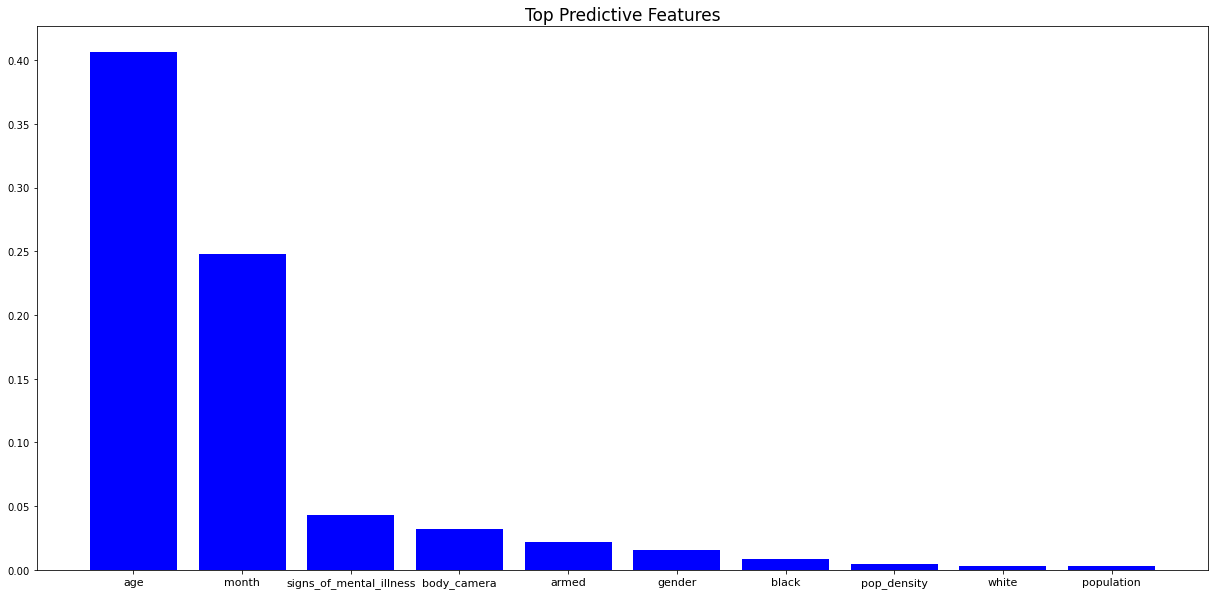

In [1953]:
# plotting feature importance first 10
top_15 = feature_data.head(10).sort_values(by='feature_importance', ascending=False)

plt.figure(figsize=(21,10))
X = np.arange(len(top_15['feature_name'].values))
ax = plt.subplot(111)
ax.bar(X, top_15['feature_importance'].values, width=0.8, color='b', align='center')

plt.xticks(rotation=0, fontsize=11)
plt.xticks(X, top_15['feature_name'].values);
plt.title("Top Predictive Features", fontsize=17)
plt.show()

### Tuning RF 

In [1961]:
params = {"max_depth": [10,20,40,None],
          'bootstrap': [True, False],
         "n_estimators": [10,100,150,200],
          "max_features": ['auto', 'sqrt'],
          "min_samples_leaf": [1, 2, 4],

}


gs_rf = model_selection.GridSearchCV(estimator=rfc,
                                 param_grid=params,
                                 cv=5,
                                 scoring="accuracy")

gs_rf.fit(X_train_select, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 40, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [10, 100, 150, 200]},
             scoring='accuracy')

In [1962]:
# Accuracy score after gridsearch 
rfc_pred_grid = gs_rf.best_estimator_.predict(X_test_select)
rf_accuracy_score_grid = accuracy_score(y_test, rfc_pred_grid)
rf_accuracy_score_grid

0.5970381917381138

In [1963]:
gs_rf.best_estimator_.score(X_train_select, y_train)

0.6387733887733887

In [1964]:
# looking at the best parameters 
gs_rf.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'n_estimators': 150}

In [1965]:
# after tuning 
print(classification_report(y_test, rfc_pred_grid))

              precision    recall  f1-score   support

           A       1.00      0.04      0.08        23
           B       0.60      0.36      0.45       336
           H       0.48      0.50      0.49       246
           N       0.00      0.00      0.00        20
           O       0.33      0.10      0.15        10
           W       0.63      0.81      0.71       648

    accuracy                           0.60      1283
   macro avg       0.51      0.30      0.31      1283
weighted avg       0.59      0.60      0.57      1283



/Users/kseniyahusak/opt/anaconda3/envs/si649f20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### So, it looks like that even with parameter grid search the accuracy for target class prediction has not improved very much - from 56% to to 58.5%, but it's still better than a random guess of 1/6 = 16.7%

## Logistic Regression

In [1853]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

# scaling features
scaler = preprocessing.StandardScaler().fit(X_train_select)
X_train_scaled = scaler.transform(X_train_select)
X_test_scaled = scaler.transform(X_test_select)

lr = LogisticRegression(max_iter=10000000,random_state = 0,multi_class='multinomial')
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           A       0.50      0.04      0.08        23
           B       0.61      0.43      0.50       336
           H       0.47      0.49      0.48       246
           N       0.00      0.00      0.00        20
           O       0.00      0.00      0.00        10
           W       0.65      0.79      0.72       648

    accuracy                           0.61      1283
   macro avg       0.37      0.29      0.30      1283
weighted avg       0.59      0.61      0.59      1283



/Users/kseniyahusak/opt/anaconda3/envs/si649f20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1854]:
# Accuracy score
log_accuracy_score = accuracy_score(y_test, lr_pred)
log_accuracy_score

0.607950116913484

#### LR tuning

In [1855]:
params_lr = {"max_iter": [20,30,50,1000],
         "C": [1.0, 2.0, 3.0]}

gs_logmodel = model_selection.GridSearchCV(estimator=lr,
                                 param_grid=params_lr,
                                 cv=5,
                                 scoring="accuracy")

gs_logmodel.fit(X_train_scaled, y_train)

/Users/kseniyahusak/opt/anaconda3/envs/si649f20/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kseniyahusak/opt/anaconda3/envs/si649f20/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000000,
                                          multi_class='multinomial',
                                          random_state=0),
             param_grid={'C': [1.0, 2.0, 3.0], 'max_iter': [20, 30, 50, 1000]},
             scoring='accuracy')

In [1856]:
# Accuracy score after gridsearch 
lr_pred_grid = gs_logmodel.best_estimator_.predict(X_test_scaled)
lr_accuracy_score = accuracy_score(y_test, lr_pred_grid)
lr_accuracy_score

0.6048324240062354

In [1857]:
gs_logmodel.best_params_

{'C': 2.0, 'max_iter': 20}

#### The accuracy score did not improve very much after tuning of parameters. However, the accuracy is better than it is in random forest. 

In [1976]:
# getting coefficients for logistic 
model=LogisticRegression(max_iter=60, C=2, multi_class='multinomial').fit(X_train_scaled, y_train) 
coeff_log=model.coef_
(model.coef_, model.intercept_);

/Users/kseniyahusak/opt/anaconda3/envs/si649f20/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [1874]:
# getting features for each class
feature_per_class = pd.DataFrame({"feature_name": selected_features, 
                                  "feature_importance_A": coeff_log[0],
                                  "feature_importance_B": coeff_log[1],
                                  "feature_importance_H": coeff_log[2],
                                  "feature_importance_N": coeff_log[3],
                                  "feature_importance_N": coeff_log[4],
                                  "feature_importance_W": coeff_log[5]
                                 }) 
feature_per_class.head(10)

,feature_name,feature_importance_A,feature_importance_B,feature_importance_H,feature_importance_N,feature_importance_W
0,armed,0.083835,-0.125264,-0.009543,-0.042794,-0.034559
1,age,0.200358,-0.139012,-0.013969,-0.503703,0.437081
2,gender,0.092768,0.043436,0.129258,-0.100087,-0.087296
3,signs_of_mental_illness,0.014266,-0.155889,-0.125528,0.156842,0.165081
4,body_camera,0.006148,0.136632,-0.011919,-0.058606,-0.081029
5,month,-0.232122,-0.017075,-0.025437,0.202557,0.002839
6,pop_density,-0.021296,0.203429,0.011185,-0.001028,0.130092
7,population,0.007473,0.005753,-0.046839,0.042613,0.017870
8,white,-0.027903,-0.048498,-0.028854,0.086536,0.110313
9,black,0.127604,0.398950,-0.210504,0.056277,-0.113254


In [1722]:
# after tuning 
print(classification_report(y_test, lr_pred_grid))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        23
           B       0.61      0.42      0.50       336
           H       0.47      0.49      0.48       246
           N       0.00      0.00      0.00        20
           O       0.00      0.00      0.00        10
           W       0.65      0.79      0.71       648

    accuracy                           0.60      1283
   macro avg       0.29      0.28      0.28      1283
weighted avg       0.58      0.60      0.58      1283



/Users/kseniyahusak/opt/anaconda3/envs/si649f20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### KNN

In [1681]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1) # k=1
knn.fit(X_train_select, y_train)
pred_knn = knn.predict(X_test_select)
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           A       0.07      0.09      0.08        23
           B       0.40      0.39      0.40       336
           H       0.35      0.37      0.36       246
           N       0.10      0.10      0.10        20
           O       0.14      0.10      0.12        10
           W       0.60      0.59      0.60       648

    accuracy                           0.48      1283
   macro avg       0.28      0.27      0.28      1283
weighted avg       0.48      0.48      0.48      1283



In [1682]:
# accuracy score
knn_accuracy_score = accuracy_score(y_test, pred_knn)
knn_accuracy_score

0.4770070148090413

### testing out different values of k

In [1683]:
rate_of_error = []

for i in range(1,100): # Checking every possible k value from 1-30

    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_select, y_train)
    pred_i = knn.predict(X_test_select)
    rate_of_error.append(np.mean(pred_i != y_test)) 

Text(0, 0.5, 'Error rate')

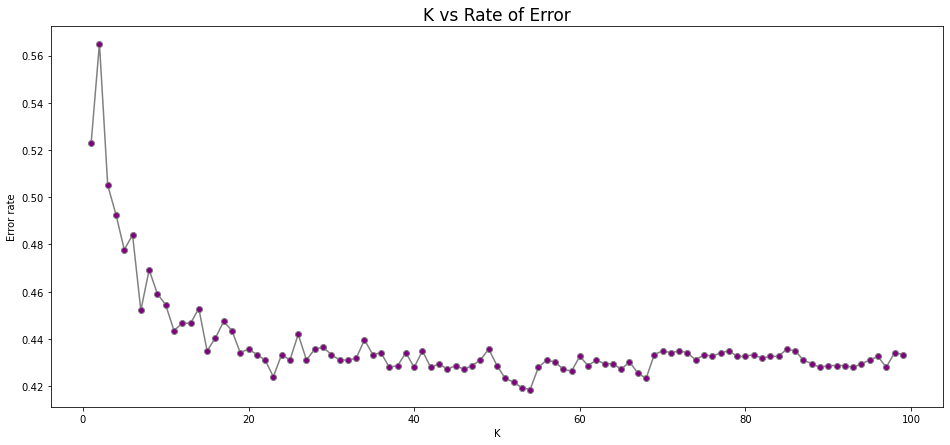

In [1684]:
# plotting results 
plt.figure(figsize=(16,7))
plt.plot(range(1,100), rate_of_error, color="grey", marker="o", markerfacecolor="purple")
plt.title("K vs Rate of Error", fontsize=17)
plt.xlabel("K")
plt.ylabel("Error rate")

It looks like around k=53 we get the lowest error rate and then it just jumps around a bunch. So that's what I will stick with. 

In [1691]:
knn = KNeighborsClassifier(n_neighbors=53)
knn.fit(X_train_select, y_train)
pred_knn = knn.predict(X_test_select)

print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        23
           B       0.54      0.34      0.42       336
           H       0.48      0.54      0.51       246
           N       0.00      0.00      0.00        20
           O       0.00      0.00      0.00        10
           W       0.63      0.77      0.69       648

    accuracy                           0.58      1283
   macro avg       0.27      0.27      0.27      1283
weighted avg       0.55      0.58      0.56      1283



/Users/kseniyahusak/opt/anaconda3/envs/si649f20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1692]:
# Accuracy score
knn_accuracy_score_tuned = accuracy_score(y_test, pred_knn)
knn_accuracy_score_tuned

0.5806703039750585

In [1723]:
# after tuning
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        23
           B       0.54      0.34      0.42       336
           H       0.48      0.54      0.51       246
           N       0.00      0.00      0.00        20
           O       0.00      0.00      0.00        10
           W       0.63      0.77      0.69       648

    accuracy                           0.58      1283
   macro avg       0.27      0.27      0.27      1283
weighted avg       0.55      0.58      0.56      1283



##### Looks like the accuracy score improved from 46.6% to about 58%. But nevertheless, it's not that much better than pure chance. 

### XGBoost

In [1768]:
from xgboost import XGBClassifier


xgb = XGBClassifier(objective="multi:softmax")
xgb.fit(X_train_select, y_train)
pred_xgb = knn.predict(X_test_select)

print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        23
           B       0.54      0.34      0.42       336
           H       0.48      0.54      0.51       246
           N       0.00      0.00      0.00        20
           O       0.00      0.00      0.00        10
           W       0.63      0.77      0.69       648

    accuracy                           0.58      1283
   macro avg       0.27      0.27      0.27      1283
weighted avg       0.55      0.58      0.56      1283



/Users/kseniyahusak/opt/anaconda3/envs/si649f20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1769]:
# Accuracy score
xgb_accuracy_score = accuracy_score(y_test, pred_xgb)
print(xgb_accuracy_score)

0.5806703039750585


#### Tuning XGBoost

In [1971]:
from sklearn.model_selection import KFold, RandomizedSearchCV

params_xgb = {"n_estimators": [1,10,40],
         "learning_rate": [0.001, 0.01, 0.1, 0.5],
             'max_depth': [1,3,10,20],
             'gamma': [0, 0.5, 2, 10],
             "subsample": [1.0, 0.9, 0.5, 0.1],
             "min_child_weight":[0.01, 0.05, 0.25, 0.75]}



# using randmomized since there's too many params 
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
gs_xgb = RandomizedSearchCV(XGBClassifier(objective="multi:softmax"),params_xgb, 
                                 scoring="accuracy", n_iter = 500, cv=kfold, random_state=0)
grid_result = gs_xgb.fit(X_train_select, y_train)



Best: 0.597976 using {'subsample': 0.1, 'n_estimators': 40, 'min_child_weight': 0.25, 'max_depth': 20, 'learning_rate': 0.01, 'gamma': 0.5}


NameError: name 'time' is not defined

In [1974]:
# summarizing results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_[ 'mean_test_score' ]
stds = grid_result.cv_results_[ 'std_test_score' ]
params = grid_result.cv_results_[ 'params' ]


Best: 0.597976 using {'subsample': 0.1, 'n_estimators': 40, 'min_child_weight': 0.25, 'max_depth': 20, 'learning_rate': 0.01, 'gamma': 0.5}


In [1972]:
# Accuracy score after gridsearch 
xgb_pred_grid = gs_xgb.best_estimator_.predict(X_test_select)
xgb_accuracy_score_gs = accuracy_score(y_test, xgb_pred_grid)
print(xgb_accuracy_score_gs)
print(classification_report(y_test, xgb_pred_grid))

0.5908028059236166
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        23
           B       0.59      0.33      0.43       336
           H       0.47      0.46      0.47       246
           N       0.00      0.00      0.00        20
           O       0.00      0.00      0.00        10
           W       0.63      0.82      0.71       648

    accuracy                           0.59      1283
   macro avg       0.28      0.27      0.27      1283
weighted avg       0.56      0.59      0.56      1283



### SVC

In [1744]:
from sklearn.svm import SVC

svm = SVC().fit(X_train_select, y_train)
pred_svm = svm.predict(X_test_select)
print(classification_report(y_test, pred_svm))

# Accuracy score
svc_accuracy_score_tuned = accuracy_score(y_test, pred_svm)
svc_accuracy_score_tuned

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        23
           B       0.00      0.00      0.00       336
           H       0.45      0.33      0.38       246
           N       0.00      0.00      0.00        20
           O       0.00      0.00      0.00        10
           W       0.54      0.91      0.67       648

    accuracy                           0.52      1283
   macro avg       0.16      0.21      0.18      1283
weighted avg       0.36      0.52      0.41      1283



/Users/kseniyahusak/opt/anaconda3/envs/si649f20/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5229929851909587

### Visualizing Results

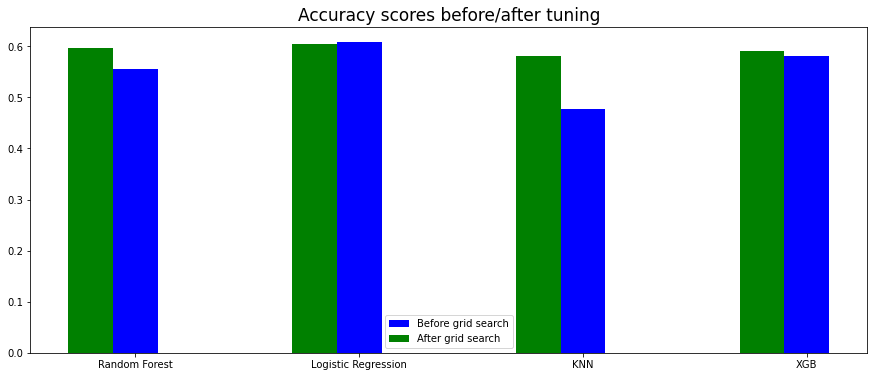

In [1973]:
# plottings accuracies 

accuracy_before = {"Random Forest": rf_accuracy_score, 
                "Logistic Regression": log_accuracy_score, 
                "KNN": knn_accuracy_score,
                  "XGB": xgb_accuracy_score}

accuracy_after = {"Random Forest": rf_accuracy_score_grid, 
                 "Logistic Regression": lr_accuracy_score, 
                 "KNN": knn_accuracy_score_tuned,
                 "XGB":xgb_accuracy_score_gs }

plt.figure(figsize=(15,6))
X = np.arange(len(accuracy_before))
ax = plt.subplot(111)
ax.bar(X, accuracy_before.values(), width=0.2, color='b', align='center')
ax.bar(X-0.2, accuracy_after.values(), width=0.2, color='g', align='center')
ax.legend(('Before grid search','After grid search'))
plt.xticks(X, accuracy_before.keys())
plt.title("Accuracy scores before/after tuning", fontsize=17)
plt.show()

#### It appears that Random Forst and Logistic are very comporable in terms of accuracy, but both give luke-warm results in terms of being better than random at predicting race. 